In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from deap.tools import initRepeat
import time # Explicitly import initRepeat


In [ ]:
# Problem Setup
max_length = 50  # Maximum length of alignment
actions = [0, 1, 2, 3]  # Example actions (alignment or gap insertion)
gap_penalty = -2

# Define Fitness and Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)



# Toolbox Setup
toolbox = base.Toolbox()

# Correctly Register Individual Creation
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, lambda: random.choice(actions), max_length
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the Fitness Function
def eval_alignment(individual):
    score = 0
    for i in range(len(individual) - 1):
        if individual[i] == individual[i + 1]:
            score += 1  # Reward for alignment
        else:
            score += gap_penalty  # Penalize gaps
    return score,

toolbox.register("evaluate", eval_alignment)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(actions)-1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=5)  # Stronger selection pressure


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
population = toolbox.population(n=300)


# Machine Learning Model Setup
ml_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)
ml_features = []
ml_targets = []
ml_model_fitted = False

In [ ]:
# Evolutionary Algorithm Execution
num_generations = 100
mutation_prob = 0.2
fitness_over_time = []
avg_fitness_over_time = []
diversity_over_time = []

In [ ]:
validation_split = 0.2
global_best_fitness = -float('inf')  # Start with a very low value for maximization problems
global_best_generation = -1

for gen in range(num_generations):
    print(f"Generation {gen}")
    fitnesses = []
    # Calculate Diversity
    diversity = len(set(tuple(ind) for ind in population)) / len(population)
    diversity_over_time.append(diversity)


    for ind in population:
        # Predict fitness using the ML model if applicable
        if gen >= 10 and ml_model_fitted:
            ind_array = np.array(ind).reshape(1, -1)
            predicted_fitness = ml_model.predict(ind_array)[0]
            ind.fitness.values = (predicted_fitness,)
            fitnesses.append(ind.fitness.values[0])
        else:
            # Evaluate fitness normally
            fit = toolbox.evaluate(ind)
            ind.fitness.values = fit
            fitnesses.append(fit[0])

            # Collect data for ML
            ml_features.append(ind.copy())
            ml_targets.append(fit[0])

    # Record Statistics
    max_fit = max(fitnesses)
    avg_fit = sum(fitnesses) / len(fitnesses)
    diversity = len(set(tuple(ind) for ind in population)) / len(population)

    fitness_over_time.append(max_fit)
    diversity_over_time.append(diversity)
    avg_fitness_over_time.append(avg_fit)

    print(f"  Max Fitness: {max_fit}")
    print(f"  Avg Fitness: {avg_fit}")
    print(f"  Diversity: {diversity}")

    if max_fit > global_best_fitness:
        global_best_fitness = max_fit
        global_best_generation = gen


        print(f"Updated Global Best Fitness: {global_best_fitness} at Generation {global_best_generation}")

    # Validation for Best Individual
    if gen >= 10 and ml_model_fitted and abs(max_fit - global_best_fitness) < 1e-6:
        best_individual = tools.selBest(population, 1)[0]
        best_individual_array = np.array(best_individual).reshape(1, -1)

        predicted_fitness = ml_model.predict(best_individual_array)[0]
        actual_fitness = eval_alignment(best_individual)[0]

        print(f"Validation for Best Individual at Generation {gen}:")
        print(f"  Predicted Fitness: {predicted_fitness}")
        print(f"  Actual Fitness: {actual_fitness}")
        print(f"  Error: {abs(predicted_fitness - actual_fitness):.2f}")

        # Calculate Validation Metrics for the Population
        population_array = np.array([np.array(ind) for ind in population])
        predicted_fitnesses = ml_model.predict(population_array)
        actual_fitnesses = [eval_alignment(ind)[0] for ind in population]

        mse = mean_squared_error(actual_fitnesses, predicted_fitnesses)
        r2 = r2_score(actual_fitnesses, predicted_fitnesses)

        print(f"Validation Metrics at Generation {gen}:")
        print(f"  MSE: {mse:.4f}")
        print(f"  R²: {r2:.4f}")

     # Adjust Mutation Probability Based on Diversity
    if gen > 20 and max_fit == fitness_over_time[-1]:
        mutation_prob = 0.5  # Increase mutation rate if fitness stagnates

    # Train ML Model Every 5 Generations
    if (gen + 1) % 5 == 0:
        if len(ml_features) > 0:
            X = np.array([np.array(ind) for ind in ml_features])
            y = np.array(ml_targets)
            split_index = int(len(X) * (1 - validation_split))
            X_train, X_val = X[:split_index], X[split_index:]
            y_train, y_val = y[:split_index], y[split_index:]

            # Train ML model
            start_time = time.time()
            ml_model.fit(X_train, y_train)
            ml_model_fitted = True
            print(f"  ML Model Trained at Generation {gen} in {time.time() - start_time:.2f} seconds")

            # Compute validation metrics
            y_val_pred = ml_model.predict(X_val)
            mse = mean_squared_error(y_val, y_val_pred)
            r2 = r2_score(y_val, y_val_pred)
            print(f"  Validation Metrics at Generation {gen}:")
            print(f"    MSE: {mse:.2f}")
            print(f"    R²: {r2:.2f}")
            print(f"  ML Model Trained at Generation {gen}")
            print(f"  ML Model Trained at Generation {gen} in {time.time() - start_time:.2f} seconds")
        else:
            print("  Not enough data to train ML model.")

    # Apply Genetic Operators
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.7:  # Crossover probability
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:  # Mutation probability
            toolbox.mutate(mutant)
            del mutant.fitness.values

    if gen % 10 == 0:
        new_individuals = [toolbox.individual() for _ in range(20)]
        offspring.extend(new_individuals)

    population[:] = offspring


Generation 0
  Max Fitness: -35
  Avg Fitness: -60.2
  Diversity: 1.0
Updated Global Best Fitness: -35 at Generation 0
Generation 1
  Max Fitness: -26
  Avg Fitness: -51.725
  Diversity: 0.915625
Updated Global Best Fitness: -26 at Generation 1
Generation 2
  Max Fitness: -23
  Avg Fitness: -43.090625
  Diversity: 0.921875
Updated Global Best Fitness: -23 at Generation 2
Generation 3
  Max Fitness: -14
  Avg Fitness: -36.4625
  Diversity: 0.91875
Updated Global Best Fitness: -14 at Generation 3
Generation 4
  Max Fitness: -14
  Avg Fitness: -30.640625
  Diversity: 0.91875


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  ML Model Trained at Generation 4 in 6.10 seconds
  Validation Metrics at Generation 4:
    MSE: 92.65
    R²: -0.67
  ML Model Trained at Generation 4
  ML Model Trained at Generation 4 in 6.11 seconds
Generation 5
  Max Fitness: -5
  Avg Fitness: -24.678125
  Diversity: 0.91875
Updated Global Best Fitness: -5 at Generation 5
Generation 6
  Max Fitness: 1
  Avg Fitness: -19.5125
  Diversity: 0.865625
Updated Global Best Fitness: 1 at Generation 6
Generation 7
  Max Fitness: 7
  Avg Fitness: -14.6375
  Diversity: 0.921875
Updated Global Best Fitness: 7 at Generation 7
Generation 8
  Max Fitness: 10
  Avg Fitness: -9.8
  Diversity: 0.9
Updated Global Best Fitness: 10 at Generation 8
Generation 9
  Max Fitness: 13
  Avg Fitness: -4.184375
  Diversity: 0.884375
Updated Global Best Fitness: 13 at Generation 9
  ML Model Trained at Generation 9 in 10.45 seconds
  Validation Metrics at Generation 9:
    MSE: 64.33
    R²: 0.10
  ML Model Trained at Generation 9
  ML Model Trained at Generat

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  ML Model Trained at Generation 29 in 11.38 seconds
  Validation Metrics at Generation 29:
    MSE: 54.99
    R²: 0.23
  ML Model Trained at Generation 29
  ML Model Trained at Generation 29 in 11.38 seconds
Generation 30
  Max Fitness: 16.215708634478364
  Avg Fitness: 12.520163819712797
  Diversity: 0.20833333333333334
Generation 31
  Max Fitness: 16.994473145789147
  Avg Fitness: 9.23840163220775
  Diversity: 0.23421052631578948
Generation 32
  Max Fitness: 17.320453788143887
  Avg Fitness: 13.042894178983655
  Diversity: 0.21842105263157896
Generation 33
  Max Fitness: 18.00010804868585
  Avg Fitness: 13.087223848565545
  Diversity: 0.2736842105263158
Generation 34
  Max Fitness: 19.447014657816354
  Avg Fitness: 13.709353378144767
  Diversity: 0.3026315789473684
  ML Model Trained at Generation 34 in 8.10 seconds
  Validation Metrics at Generation 34:
    MSE: 63.80
    R²: 0.11
  ML Model Trained at Generation 34
  ML Model Trained at Generation 34 in 8.11 seconds
Generation 35


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  ML Model Trained at Generation 39 in 11.74 seconds
  Validation Metrics at Generation 39:
    MSE: 64.64
    R²: 0.09
  ML Model Trained at Generation 39
  ML Model Trained at Generation 39 in 11.74 seconds
Generation 40
  Max Fitness: 17.191989081316258
  Avg Fitness: 6.3315167744133225
  Diversity: 0.2710526315789474
Generation 41
  Max Fitness: 17.191989081316258
  Avg Fitness: 4.866322195646593
  Diversity: 0.3275
Generation 42
  Max Fitness: 20.712260263592135
  Avg Fitness: 10.21911361265267
  Diversity: 0.3525
Generation 43
  Max Fitness: 21.480227966674445
  Avg Fitness: 11.984780705013007
  Diversity: 0.33
Generation 44
  Max Fitness: 21.887245972391415
  Avg Fitness: 14.0134006388377
  Diversity: 0.31


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  ML Model Trained at Generation 44 in 11.18 seconds
  Validation Metrics at Generation 44:
    MSE: 57.39
    R²: 0.20
  ML Model Trained at Generation 44
  ML Model Trained at Generation 44 in 11.18 seconds
Generation 45
  Max Fitness: 17.557635259677458
  Avg Fitness: 8.784444630726618
  Diversity: 0.34
Generation 46
  Max Fitness: 18.680977709710746
  Avg Fitness: 11.48301810509753
  Diversity: 0.3
Generation 47
  Max Fitness: 19.70086037962979
  Avg Fitness: 13.501983566538767
  Diversity: 0.28
Generation 48
  Max Fitness: 23.739756697375583
  Avg Fitness: 14.964875166302283
  Diversity: 0.325
Generation 49
  Max Fitness: 23.739756697375583
  Avg Fitness: 16.600402709479134
  Diversity: 0.335
  ML Model Trained at Generation 49 in 9.66 seconds
  Validation Metrics at Generation 49:
    MSE: 54.06
    R²: 0.24
  ML Model Trained at Generation 49
  ML Model Trained at Generation 49 in 9.67 seconds
Generation 50
  Max Fitness: 24.390531945277736
  Avg Fitness: 15.009230132013322
  Di

In [ ]:
if best_predicted_fitnesses and best_actual_fitnesses:
    mse = mean_squared_error(best_actual_fitnesses, best_predicted_fitnesses)
    r2 = r2_score(best_actual_fitnesses, best_predicted_fitnesses)

    print(f"Validation Metrics for Global Best Fitness Model (Generation {global_best_generation}):")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  R² Score: {r2:.4f}")
else:
    print("No data available for best fitness validation.")


NameError: name 'best_predicted_fitnesses' is not defined

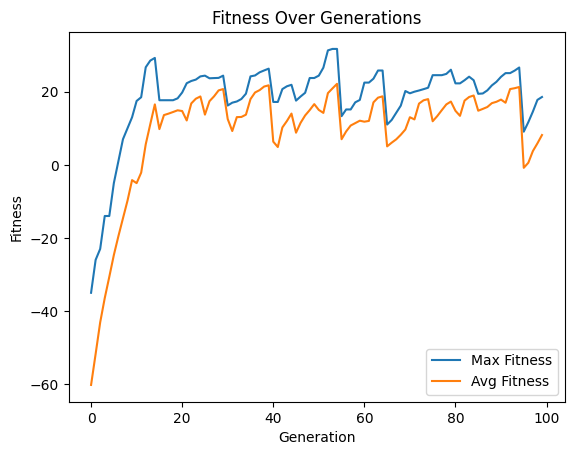

In [ ]:
# Plot Fitness Over Time
plt.plot(fitness_over_time, label="Max Fitness")
plt.plot(avg_fitness_over_time, label="Avg Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Over Generations")
plt.legend()
plt.show()


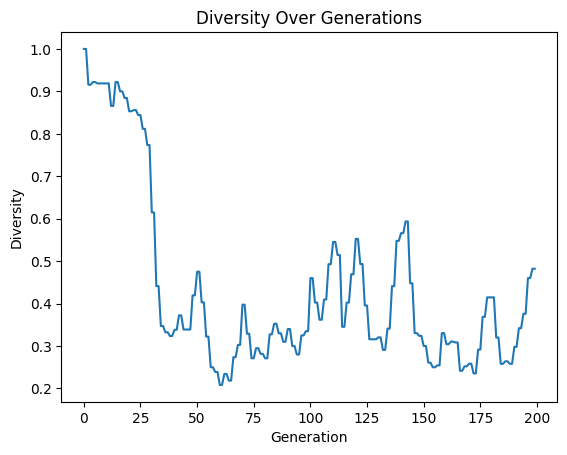

In [ ]:
# Plot Diversity Over Time
plt.plot(diversity_over_time)
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Diversity Over Generations")
plt.show()

In [ ]:
# Display Best Individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best Individual: {best_individual}")
print(f"Best Fitness: {best_individual.fitness.values[0]}")

# Validation for Best Individual


Best Individual: [2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 3, 0, 2, 0, 2, 2, 3, 3, 0, 3, 3, 1, 1, 0]
Best Fitness: 18.54911446569569


In [ ]:
print(f"ML Model Fitted: {ml_model_fitted}")
print(f"Population size: {len(population)}")
print(f"Best Individual Fitness: {tools.selBest(population, 1)[0].fitness.values[0]}")
print(f"  max(fitness_over_time): {max(fitness_over_time)}")
print(f"  Condition Result: {gen >= 10 and ml_model_fitted and abs(max_fit - max(fitness_over_time)) < 1e-6}")

if gen >= 10 and ml_model_fitted and abs(max_fit - max(fitness_over_time)) < 1e-6:
  best_individual = tools.selBest(population, 1)[0]
  best_individual_array = np.array(best_individual).reshape(1, -1)

  predicted_fitness = ml_model.predict(best_individual_array)[0]
  actual_fitness = eval_alignment(best_individual)[0]

  print(f"Validation for Best Individual at Generation {gen}:")
  print(f"  Predicted Fitness: {predicted_fitness}")
  print(f"  Actual Fitness: {actual_fitness}")
  print(f"  Error: {abs(predicted_fitness - actual_fitness):.2f}")

ML Model Fitted: True
Population size: 500
Best Individual Fitness: 18.54911446569569
  max(fitness_over_time): 31.696053618689835
  Condition Result: False


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Convert collected data to arrays
X = np.array([np.array(ind) for ind in ml_features])  # Features
y = np.array(ml_targets)  # Targets (alignment scores)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train Gradient Boosting Regressor (or another ML model)
ml_model = GradientBoostingRegressor()
ml_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ml_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"ML Model RMSE: {rmse:.2f}")
print(f"ML Model R²: {r2:.2f}")


ML Model RMSE: 7.26
ML Model R²: 0.86


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Find the best fitness value
best_ga_fitness = max(fitness_over_time)

# Find the generation where the best fitness was achieved
best_generation = fitness_over_time.index(best_ga_fitness)

print(f"Best GA Fitness: {best_ga_fitness}")
print(f"Achieved at Generation: {best_generation}")



Best GA Fitness: 31.696053618689835
Achieved at Generation: 53


In [ ]:
import matplotlib.pyplot as plt

methods = ['GA Best Fitness', 'ML Predicted Avg Fitness']
values = [best_ga_fitness, avg_ml_fitness]

plt.bar(methods, values)
plt.ylabel('Fitness')
plt.title('Fitness Comparison')
plt.show()


NameError: name 'avg_ml_fitness' is not defined

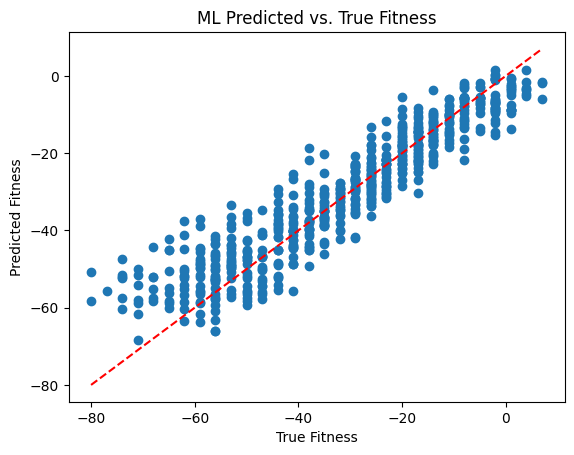

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Fitness')
plt.ylabel('Predicted Fitness')
plt.title('ML Predicted vs. True Fitness')
plt.show()


In [ ]:
fitness_values = [ind.fitness.values[0] for ind in population]
print(f"Final Population Fitness Values: {fitness_values}")
print(f"Fitness Standard Deviation: {np.std(fitness_values)}")


IndexError: tuple index out of range